# 📘 RAndom forest - Predicción de MatchKills

Usando la variable `TimeAlive` como predictor.

## 1. Importar Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
from scipy.stats import randint, uniform
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline


## 2. Carga del Dataset

In [ ]:
# Upload the CSV file
uploaded = files.upload()

# Read the CSV file
for file_name in uploaded.keys():
    df = pd.read_csv(file_name, sep=';')

Saving Anexo ET_demo_round_traces_2022 (1).csv to Anexo ET_demo_round_traces_2022 (1).csv


In [ ]:
# Preprocesamiento de columnas numéricas
columnas_numericas = ['TimeAlive', 'MatchAssists', 'MatchHeadshots', 'TeamStartingEquipmentValue', 'MatchKills']

for col in columnas_numericas:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=columnas_numericas)
df.head()


,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0


## 3. Análisis Exploratorio de Datos (EDA)

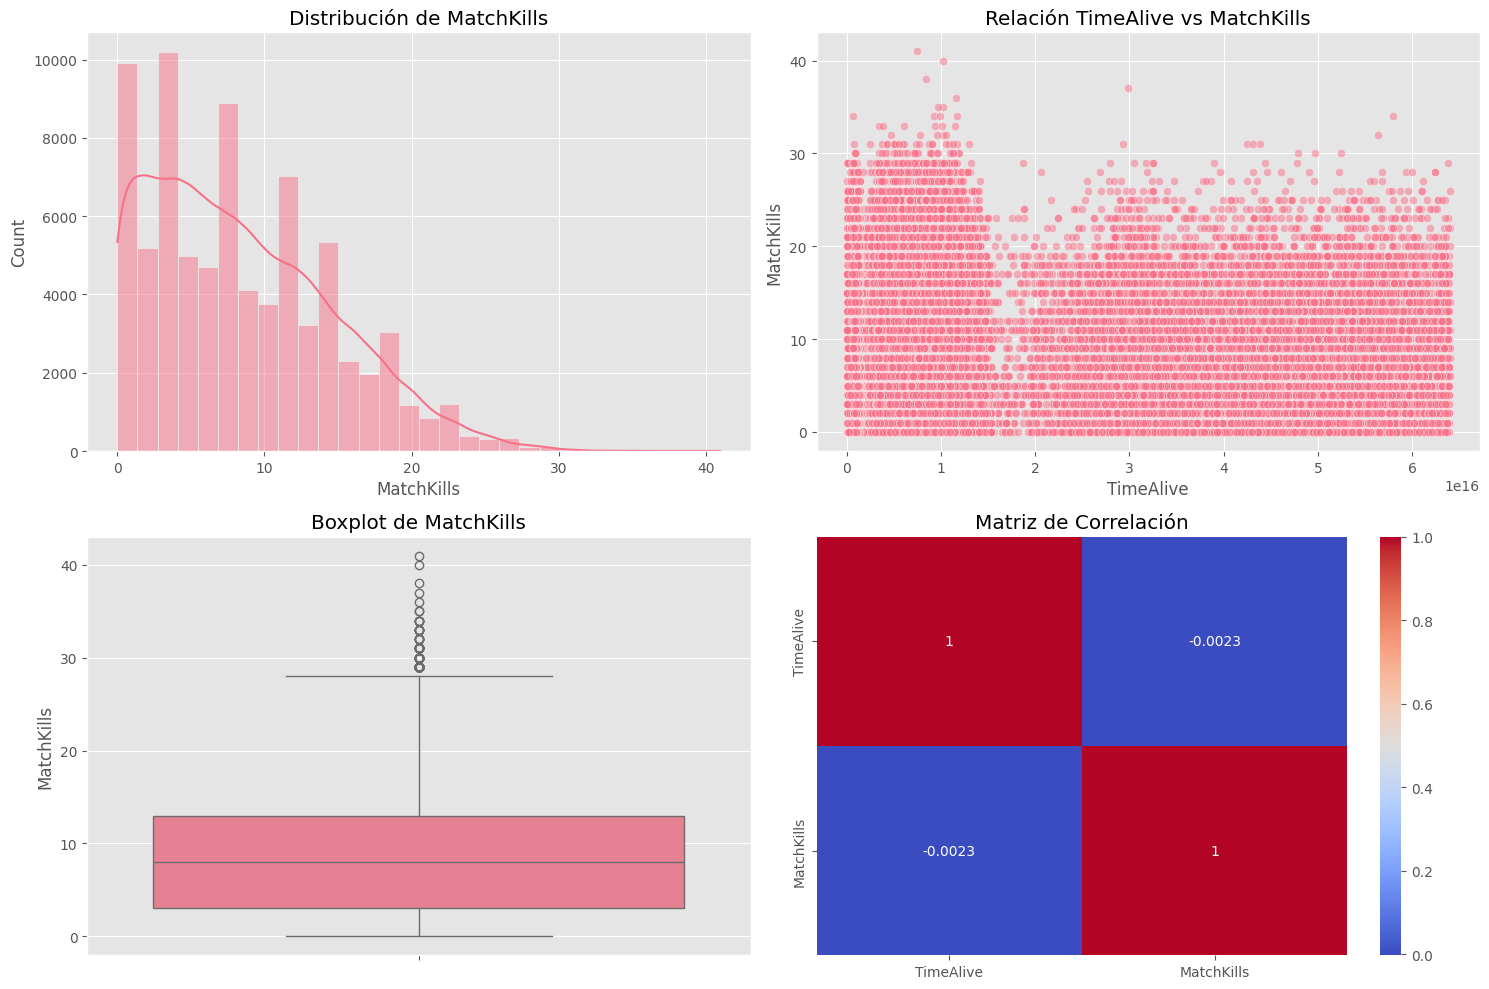

In [ ]:
print("Resumen estadístico:")
print(df[columnas_numericas].describe())

plt.figure(figsize=(18, 12))

# Distribución de variables
for i, col in enumerate(columnas_numericas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

# Correlaciones
plt.figure(figsize=(10, 8))
corr_matrix = df[columnas_numericas].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

## 4. Preparación de Datos para el Modelo

In [ ]:
# Selección de características y target
X = df[['TimeAlive', 'MatchAssists', 'MatchHeadshots', 'TeamStartingEquipmentValue']]
y = df['MatchKills']

# División train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Escalado opcional (menos crítico que en SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Modelado con Random Forest

In [ ]:
# Configuración del modelo base
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Espacio de parámetros para búsqueda aleatoria
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None] + list(np.arange(5, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Búsqueda aleatoria de parámetros
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)



Iniciando entrenamiento con GridSearch...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
print("\nIniciando entrenamiento con RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_rf = random_search.best_estimator_
print("\nMejores parámetros encontrados:")
print(random_search.best_params_)

## 6. Evaluación del Modelo

In [ ]:
# Predicciones
y_pred_train = best_rf.predict(X_train_scaled)
y_pred_test = best_rf.predict(X_test_scaled)

# Métricas completas
print("\nMétricas de Evaluación:")
print("=== Conjunto de Entrenamiento ===")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"R2: {r2_score(y_train, y_pred_train):.2f}")

print("\n=== Conjunto de Prueba ===")
print(f"MSE: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"R2: {r2_score(y_test, y_pred_test):.2f}")

# Visualización de resultados
plt.figure(figsize=(15, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (Test)')

# Distribución de residuos
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')

plt.tight_layout()
plt.show()

## 7. Interpretación del Modelo

In [ ]:
# Importancia de características
feature_importance = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis')
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

# Predicciones parciales (para la característica principal)
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    best_rf,
    X_train_scaled,
    features=[np.argmax(feature_importance)],
    feature_names=features,
    grid_resolution=50
)
plt.title('Dependencia Parcial para la Característica Principal')
plt.tight_layout()
plt.show()


## 8. Despliegue del Modelo

In [ ]:
# Guardar modelo y scaler
joblib.dump(best_rf, 'mejor_modelo_rf.pkl')
joblib.dump(scaler, 'scaler_rf.pkl')

print("\nModelo y scaler guardados como 'mejor_modelo_rf.pkl' y 'scaler_rf.pkl'")
